Schema Matching

In [1]:
# Mediated schema definition

mediated_schema = [
    "Patient_identfication_number", "First_Last_Names", "Age", "Patient_gender", "diabetes",
    "heart_disease_status", "Systolic_BP", "Diaolistic_BP",
    "bmi", "cholesterol", "smoker", "medications"
]


GT_dict_heart ={ 
        "Patient_identfication_number": "patient_id", #string matcher
        "First_Last_Names": "name", #string matcher
        "Age": "age", #string matcher
        "Patient_gender": "sex", #string matcher
        "heart_disease_status": "target", #semantic matcher. but might still yield back weak results
        "cholesterol": "chol", #string matcher
        "smoker": "smoke" #string matcher
        
}

In [2]:
#data modification and data prep

import pandas as pd

heart_df = pd.read_csv('../../Datasets/heart_ready.csv')
relevant_cols = ['patient_id', 'name', 'age', 'sex', 'num', 'chol', 'smoke']
irrelevant_keep = ['cp', 'trestbps', 'restecg', 'oldpeak', 'slope']
final_columns = relevant_cols + irrelevant_keep
heart_df_reduced = heart_df[final_columns]
heart_df_reduced = heart_df_reduced.rename(columns={'num': 'target'})
heart_df_reduced.to_csv("heart_ready_reduced.csv", index=False)

#extracting a list of columsn names from the heart disease data source post-processing.
Heart_DS = list(heart_df_reduced.columns)

print(Heart_DS)


['patient_id', 'name', 'age', 'sex', 'target', 'chol', 'smoke', 'cp', 'trestbps', 'restecg', 'oldpeak', 'slope']


# Semantic matchers

The following sections includes two semantic matchers. Both matchers use pre-trained models.
First semantic matcher, outlined in Semantic_Matcher.py uses pre-trained LLM model, where the initialisation of the matcher allows for passing of different pre-trained LLM. 

The second matcher uses a pre-trained word2vec. Where simialry to the previous semantic matcher it is also built in a way that allows specifying the pre-trained model at the tme of initialisation.

The LLM-based semantic matchers uses a modified cosine similarity, that considers values expected by the mediated schema and a sample from the source data. (See cosine simialry equation in the report). While the word2vec use the standard cosine similarity considering 2 vectors irrespective of other factors, (Vec1: tokenized column names from the mediated schema, Vec2: Tokenized column names from the source data).

In [3]:
#embedding-based semantic matcher

import pandas as pd
import sys
sys.path.append('..')  
from LLM_Matcher import LLM_Matcher


# The model was giving incorrect results for the patient_gender / sex. 
# the expectaions were added so the matcher would consider both the name of the column and the values.
# the mediated schema focuses on "patients", which can be a bit problematic when the matcher is only considering the column names,
# as the word "patient" could appear multiple times in different context in the data source, the final similarity matrix would give a high cosine similarity value for unmatched columns
# an additional point to look at would be setting up the matcher to know what to expcet. meaning the matcher would consider the column names for both the MS and the DS, the source value, and the expected value and would give the cosine similary 
# (note to self, see cosine similiary equation on notebook, and add in the report)
# in addition, considering the overall trend of values in the data source is numerical, and the fact that in this specific data source, categorical data is numerical, binary. a
# an additional mapping for the specific case of "sex" column was added in panda dataframe to map the binary values to the categorical values, set up the values the mediated schema is expecting to recieve
schema_expectations = {
    "Patient_identfication_number": [],
    "First_Last_Names": [],
    "Age": [],
    "Patient_gender": ["Male", "Female"],
    "diabetes": ["Yes", "No"],
    "heart_disease_status": ["Yes", "No"],
    "Systolic_BP": [],
    "Diaolistic_BP": [],
    "bmi": [],
    "cholesterol": [],
    "smoker": ["Yes", "No"],
    "medications": []
}

heart_df_reduced['sex'] = heart_df_reduced['sex'].map({1: 'Male', 0: 'Female'})

#weights were tweeked based on trial and error to find the most optimal weighting that would yeild correct results for the spcific case of gender-sex

matcher = LLM_Matcher(
    model_name='multi-qa-MiniLM-L6-cos-v1',
    name_weight=0.4,
    source_value_weight=0.3,
    expected_value_weight=0.3
)

#inclyding schema expectations in the matcher model
similarity_matrix_SM, best_matches_SM = matcher.match(mediated_schema, schema_expectations, heart_df_reduced)

similarity_matrix_SM.to_csv("similarity_matrix_LLM_Matcher.csv")
similarity_matrix_SM.to_latex("latex_tabels/Heart_LLM_Matcher_Sim_Matrix.tex" , float_format="%.3f")
best_matches_SM.to_csv("best_matches_miniML.csv", index=False)

#reults for best matches, to manually review the correctness of the results
print("Best matches for embedding-based semantic matcher:\n",best_matches_SM)

c:\Users\balkh\miniconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Best matches for embedding-based semantic matcher:
                  mediated_column source_column  similarity_score
0   Patient_identfication_number    patient_id          0.806350
1               First_Last_Names          name          0.474425
2                            Age           age          0.893985
3                 Patient_gender           sex          0.735366
4                       diabetes           sex          0.255689
5           heart_disease_status    patient_id          0.445049
6                    Systolic_BP            cp          0.379216
7                  Diaolistic_BP            cp          0.317816
8                            bmi           sex          0.193359
9                    cholesterol          chol          0.485466
10                        smoker         smoke          0.598871
11                   medications         smoke          0.168994


In [5]:
#word2vec matcher
from gensim.models import KeyedVectors
from word2vec_Matcher import word2Vec_matcher
import kagglehub

#Google pre-trained model was downloaded using Kugglehub. Model wa added in .gitignore as it's +3 GB.
#in order to be able to run this code snippet, either downlaod the model manually, or uncomment the following code:
#path = kagglehub.dataset_download("leadbest/googlenewsvectorsnegative300")
# the previous line downloads the used model.
#Word2Vec_matcher class allows for the usage of other models. I assume other pre-trained models need to be downlaoded manuallt and added in the models folder in the projcet directory


model_path = "../Models/GoogleNews-vectors-negative300.bin"
pretrained = KeyedVectors.load_word2vec_format(model_path, binary=True)

matcher = word2Vec_matcher(model=pretrained)

similarity_matrix_word2vec, best_matches_word2vec = matcher.match_schemas( mediated_schema=mediated_schema, source_schema=Heart_DS)

similarity_matrix_word2vec.to_csv("similarity_matrix_SemanticMatcher.csv")

similarity_matrix_word2vec.to_latex("latex_tabels/Heart_word2vec_Matcher_Sim_Matrix.tex", float_format="%.3f")
best_matches_word2vec.to_csv("best_matches_miniML.csv", index=False)

print("Best matches for word2vec matcher\n",best_matches_word2vec)


Best matches for word2vec matcher
                  mediated_column source_column  similarity_score
0   Patient_identfication_number    patient_id             0.969
1               First_Last_Names      trestbps             0.912
2                            Age           age             0.897
3                 Patient_gender       restecg             0.943
4                       diabetes       restecg             0.939
5           heart_disease_status      trestbps             0.957
6                    Systolic_BP    patient_id             0.858
7                  Diaolistic_BP    patient_id             0.884
8                            bmi    patient_id             0.831
9                    cholesterol         slope             0.942
10                        smoker         smoke             0.983
11                   medications    patient_id             0.954


# Sequence-based String matcher

Using longest contiguous matching subsequence

In [6]:
from difflib import SequenceMatcher

def string_matcher_LCMS(schema1, schema2):
    matrix = []
    for col1 in schema1:
        row = []
        for col2 in schema2:
            #longest contiguous matching subsequence
            score = SequenceMatcher(None, col1.lower(), col2.lower()).ratio()
            row.append(round(score,7))
        matrix.append(row)
    return pd.DataFrame(matrix, index=schema1, columns=schema2)

In [7]:
import pandas as pd


## updated to include the full similarity matrix in the CSV, while also storing the best matches

string_similarity_LCMS = string_matcher_LCMS(mediated_schema, Heart_DS)
string_similarity_LCMS.to_csv("similarity_matrix_LCMS.csv", index=True)
string_similarity_LCMS.to_latex("latex_tabels/Heart_LCMS_Matcher_Sim_Matrix.tex", float_format="%.3f")

best_matches = []

for mediated_col in string_similarity_LCMS.index:
    row = string_similarity_LCMS.loc[mediated_col]
    best_source_col = row.idxmax()
    best_score = row.max()
    best_matches.append((mediated_col, best_source_col, best_score))

best_matches_df = pd.DataFrame(best_matches, columns=["mediated_column", "source_column", "similarity_score"])

best_matches_df.to_csv("best_matches_LCMS.csv", index=False)

best_matches_df

,mediated_column,source_column,similarity_score
0,Patient_identfication_number,patient_id,0.526316
1,First_Last_Names,name,0.400000
2,Age,age,1.000000
3,Patient_gender,patient_id,0.750000
4,diabetes,target,0.428571
5,heart_disease_status,trestbps,0.285714
6,Systolic_BP,trestbps,0.421053
7,Diaolistic_BP,trestbps,0.380952
8,bmi,name,0.285714
9,cholesterol,chol,0.533333


# Set-based String Matcher

Using Jaccard

In [8]:
import re
from rapidfuzz.fuzz import ratio


def soft_jaccard(set1, set2, threshold=0):
    total_sim = 0.0
    for token1 in set1:
        best = max(ratio(token1, token2) / 100.0 for token2 in set2) if set2 else 0
        total_sim += best  
    
    union = len(set1) + len(set2) - total_sim  
    return total_sim / union if union > 0 else 0.0


def tokenize(text):
    return text.lower().replace("_", " ").split()


tokens1_list = [tokenize(c) for c in mediated_schema]
print(f"Mediated schema tokens{tokens1_list}")

tokens2_list =[tokenize(c) for c in Heart_DS]
print(f"Source data to tokens{tokens2_list}")

matrix = []
for col1 in mediated_schema:
    tokens1 = tokenize(col1)
    row = []
    for col2 in Heart_DS:
        tokens2 = tokenize(col2)
        score = soft_jaccard(tokens1, tokens2)
        row.append(round(score, 7))  #rounding to be inline with other matchers
    matrix.append(row)
similarity_matrix_jaccard = pd.DataFrame(matrix, index=mediated_schema, columns=Heart_DS)

similarity_matrix_jaccard.to_csv("similarity_matrix_softJaccard.csv", float_format="%.7f")
similarity_matrix_jaccard.to_latex("latex_tabels/Heart_FJaccard_Matcher_Sim_Matrix.tex", float_format="%.3f")
best_matches = [] 

print(similarity_matrix_jaccard)
for col in similarity_matrix_jaccard.index:
    row = similarity_matrix_jaccard.loc[col]
    best_match = row.idxmax()
    best_score = row.max()
    best_matches.append((col, best_match, best_score))

best_matches_df = pd.DataFrame(best_matches, columns=["mediated_column", "source_column", "similarity_score"])
best_matches_df.to_csv("best_matches_softJaccard.csv", index=False, float_format="%.7f")

Mediated schema tokens[['patient', 'identfication', 'number'], ['first', 'last', 'names'], ['age'], ['patient', 'gender'], ['diabetes'], ['heart', 'disease', 'status'], ['systolic', 'bp'], ['diaolistic', 'bp'], ['bmi'], ['cholesterol'], ['smoker'], ['medications']]
Source data to tokens[['patient', 'id'], ['name'], ['age'], ['sex'], ['target'], ['chol'], ['smoke'], ['cp'], ['trestbps'], ['restecg'], ['oldpeak'], ['slope']]
                              patient_id      name       age       sex  \
Patient_identfication_number    0.450893  0.428026  0.229718  0.158488   
First_Last_Names                0.259542  0.398058  0.244444  0.244444   
Age                             0.153846  0.400000  1.000000  0.200000   
Patient_gender                  0.485714  0.341463  0.391753  0.163793   
diabetes                        0.153846  0.200000  0.222222  0.100000   
heart_disease_status            0.227518  0.244500  0.278863  0.278863   
Systolic_BP                     0.139240  0.000000  0.0

combiners:
combination techniques

schema matching steps:
a set of matchers.. combiner.. selector

combiners
think in ML, combingin layers and lookinh at results. min, avg max, weighted avg (weights are given t different )
different combos can be used based on use case
(recommendation is to use all of them)



** make sure all matchers are normalized before using combination straegies. (1-0)
applying thershold and converting to 1-0. (ie., >0.5 conver to 1 and other to 0)
tweaking teh weights for wehigehted avg is better apparnt after the sleection process, as byt then hyou wouil dhave the performance matix


Performance (later, but to get an idea on what to consdier)
- precision: how precise was my model in predication 
- recall: 
- F1 score:


* define a ground truth matrix
clacualte TP, FP, FN against the ground truth matrix 

Dtratgies to minimzie execution time could conaisder parallel processing 
createthe ground truth matrix by the end of this week. 



In [9]:


#adding ground truth table
ground_truth_matrix = pd.DataFrame(
    0,
    index=mediated_schema,
    columns=heart_df_reduced.columns
)

for mediated_col, source_col in GT_dict_heart.items():
    ground_truth_matrix.loc[mediated_col, source_col] = 1

print(ground_truth_matrix)


ground_truth_matrix.to_csv("GTT.csv", float_format="%.7f")
ground_truth_matrix.to_latex("latex_tabels/Heart_Ground_Truth_matrix.tex", index= True, float_format="%f")
#

                              patient_id  name  age  sex  target  chol  smoke  \
Patient_identfication_number           1     0    0    0       0     0      0   
First_Last_Names                       0     1    0    0       0     0      0   
Age                                    0     0    1    0       0     0      0   
Patient_gender                         0     0    0    1       0     0      0   
diabetes                               0     0    0    0       0     0      0   
heart_disease_status                   0     0    0    0       1     0      0   
Systolic_BP                            0     0    0    0       0     0      0   
Diaolistic_BP                          0     0    0    0       0     0      0   
bmi                                    0     0    0    0       0     0      0   
cholesterol                            0     0    0    0       0     1      0   
smoker                                 0     0    0    0       0     0      1   
medications                 

# Combiners

In [10]:
def average_combiner(similarity_matrix, threshold = 0.5):
    num = len(similarity_matrix)
    first = next(iter(similarity_matrix.values()))
    
    combined_array = sum(matrix.values for matrix in similarity_matrix.values()) / num

    combined_array[combined_array < threshold] = 0.0
    combined_df = pd.DataFrame(combined_array, index=first.index, columns=first.columns)
    print(combined_df)
    return combined_df

In [11]:
import numpy as np
def max_combiner(similarity_matrix, threshold= 0.5):
    first = next(iter(similarity_matrix.values()))
    shape = first.shape

    combined_array = np.zeros(shape)

    for matrix in similarity_matrix.values():
        combined_array = np.maximum(combined_array, matrix.values)

   
    combined_array[combined_array < threshold] = 0.0
    combined_df = pd.DataFrame(combined_array, index=first.index, columns=first.columns)
    print(combined_df)
    return combined_df

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from itertools import product
from sklearn.metrics import  precision_score, recall_score, f1_score


#the following function imeplemnted a weighted average combiners. the weights are assigned through testing out all the different combination of weights that amount up to 1 (.1f)
def optimize_weights(sim_matrices, ground_truth, threshold=0.6, step=0.1):

    names = list(sim_matrices.keys())
    n = len(names)

    # generate all weight combinations that sum to 1
    grids = [np.arange(0, 1 + step, step) for _ in range(n)]
    weight_combos = [combo for combo in product(*grids) if np.isclose(sum(combo), 1.0)]

    best_f1 = -1
    best_weights = None
    best_matrix = None

    #in general, works in this case as we only have three matchers, but could be computational expensive if we had multiple matchers
    for combo in weight_combos:
        # combine matrices
        combined = sum(w * sim_matrices[name].values for w, name in zip(combo, names))
        binary_pred = (combined >= threshold).astype(int)
        y_pred = binary_pred.flatten()
        y_true = ground_truth.values.flatten()

        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_weights = dict(zip(names, combo))
            best_matrix = pd.DataFrame(combined, index=ground_truth.index, columns=ground_truth.columns)
    print("best Weights:", best_weights)
    
    return best_matrix



In [13]:
#Harmony-based adative matcher combination (HADAPT)
#referencing Peukert,E Massman, S, & Konig, K. comparing similarity combination methods for schema matching
# A Harmony based Adaptive Ontology Mapping Approach: Ming Mao1, Yefei Peng2, and Michael Spring
# works on our case as we are only working one-to-one mapping

def Harmony(similarity_matrices):
    arr = similarity_matrices.values
    row_max = (arr == np.max(arr, axis=1, keepdims=True))
    col_max = (arr == np.max(arr, axis=0, keepdims=True))
    both_max = np.logical_and(row_max, col_max)
    count = np.sum(both_max)
    norm_factor = max(arr.shape[0], arr.shape[1])
    return count / norm_factor if norm_factor > 0 else 0.0


def HADAPT_Weights(similarity_matrices):
    harmony_scores = {}
    for name, matrix in similarity_matrices.items():
        harmony_scores[name] = Harmony(matrix)
    
    total = sum(harmony_scores.values())
    if total == 0:
        n = len(harmony_scores)
        return {name: 1 / n for name in harmony_scores}
    print(harmony_scores)
    return {name: score / total for name, score in harmony_scores.items()}

def combine_sim_HADAPT(similarity_matrices):
    weights = HADAPT_Weights(similarity_matrices)
    first_matrix = next(iter(similarity_matrices.values()))
    
    combined_array = sum(
        weights[name] * similarity_matrices[name].values
        for name in similarity_matrices)
    combined_sim_matrix = pd.DataFrame(combined_array, index=first_matrix.index, columns= first_matrix.columns)
    return combined_sim_matrix

In [14]:
#Evaluation

def evaluate(combined_matrix, threshold, ground_truth_matrix, case_name=None,
             sim_matrix_dict=None, combination_technique=None):
    predicted_matrix = (combined_matrix >= threshold).astype(int)
    y_pred = predicted_matrix.values.flatten()
    y_true = ground_truth_matrix.values.flatten()

    # evaluate
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)


    #Evaluation outputs
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1:.3f}")    

    return {
        "case": case_name,
        "matchers": " + ".join(sim_matrix_dict.keys()) if sim_matrix_dict else "N/A",
        "Combiner": combination_technique,
        "threshold": threshold,
        "precision": round(precision, 3),
        "recall": round(recall, 3),
        "f1_score": round(f1, 3)
    }

#for storing combiner results for selection
evaluation_results = []

In [15]:
#weighted average for SM, LCMS, fuzzy-jaccard, Word2vec
similarity_matrices_case1 = {

    "semantic": similarity_matrix_SM,
    "LCMS": string_similarity_LCMS,
    "Jaccard": similarity_matrix_jaccard,
    "word2vec": similarity_matrix_word2vec
}

combined_matrix_case1 = optimize_weights(similarity_matrices_case1, ground_truth_matrix)
res1 = evaluate(
    combined_matrix=combined_matrix_case1,
    threshold=0.6,
    ground_truth_matrix=ground_truth_matrix,
    case_name="Case 1",
    sim_matrix_dict=similarity_matrices_case1,
    combination_technique="Weighted Avg"
)


evaluation_results.append(res1)

best Weights: {'semantic': 0.4, 'LCMS': 0.0, 'Jaccard': 0.1, 'word2vec': 0.5}
Precision: 0.750
Recall: 0.857
F1-score: 0.800


In [16]:
#weighted average for SM, LCMS, Word2vec
similarity_matrices_case2 = {
    "semantic": similarity_matrix_SM,
    "LCMS": string_similarity_LCMS,
    "word2vec": similarity_matrix_word2vec
}

best_combined = optimize_weights(similarity_matrices_case2, ground_truth_matrix)

combined_matrix_case2 = optimize_weights(similarity_matrices_case1, ground_truth_matrix)
res2 = evaluate(
    combined_matrix=combined_matrix_case2,
    threshold=0.6,
    ground_truth_matrix=ground_truth_matrix,
    case_name="Case 2",
    sim_matrix_dict=similarity_matrices_case2,
    combination_technique="Weighted Avg"
)
evaluation_results.append(res2)

best Weights: {'semantic': 0.4, 'LCMS': 0.1, 'word2vec': 0.5}
best Weights: {'semantic': 0.4, 'LCMS': 0.0, 'Jaccard': 0.1, 'word2vec': 0.5}
Precision: 0.750
Recall: 0.857
F1-score: 0.800


In [17]:
#weighted average for SM, fuzz-jaccard, Word2vec

similarity_matrices_case3 = {
    "semantic": similarity_matrix_SM,
    "Jaccard": similarity_matrix_jaccard,
}

combined_matrix_case3 = optimize_weights(similarity_matrices_case3, ground_truth_matrix)

res3 = evaluate(
    combined_matrix=combined_matrix_case3,
    threshold=0.6,
    ground_truth_matrix=ground_truth_matrix,
    case_name="Case 3",
    sim_matrix_dict=similarity_matrices_case3,
    combination_technique="Weighted Avg"
)
evaluation_results.append(res3)

best Weights: {'semantic': 0.8, 'Jaccard': 0.2}
Precision: 1.000
Recall: 0.571
F1-score: 0.727


In [18]:
#weighted average for SM, Word2vec


similarity_matrices_case4 = {
    "semantic": similarity_matrix_SM,
    "LCMS": string_similarity_LCMS,
}

combined_matrix_case4 = optimize_weights(similarity_matrices_case4, ground_truth_matrix)


res4 = evaluate(
    combined_matrix=combined_matrix_case4,
    threshold=0.6,
    ground_truth_matrix=ground_truth_matrix,
    case_name="Case 4",
    sim_matrix_dict=similarity_matrices_case4,
    combination_technique="Weighted Avg"
)
evaluation_results.append(res4)



best Weights: {'semantic': 0.8, 'LCMS': 0.2}
Precision: 1.000
Recall: 0.571
F1-score: 0.727


In [19]:
#Average for SM, LCMS  

similarity_matrices_case5 = {
    "semantic": similarity_matrix_SM,
    "LCMS": string_similarity_LCMS,
}

combined_matrix_case5 = average_combiner(similarity_matrices_case5)

res5 = evaluate(
    combined_matrix=combined_matrix_case5,
    threshold=0.6,
    ground_truth_matrix=ground_truth_matrix,
    case_name="Case 5",
    sim_matrix_dict=similarity_matrices_case5,
    combination_technique="Avg"
)
evaluation_results.append(res5)


                              patient_id  name       age  sex  target    chol  \
Patient_identfication_number    0.666333   0.0  0.000000  0.0     0.0  0.0000   
First_Last_Names                0.000000   0.0  0.000000  0.0     0.0  0.0000   
Age                             0.000000   0.0  0.946992  0.0     0.0  0.0000   
Patient_gender                  0.620692   0.0  0.000000  0.0     0.0  0.0000   
diabetes                        0.000000   0.0  0.000000  0.0     0.0  0.0000   
heart_disease_status            0.000000   0.0  0.000000  0.0     0.0  0.0000   
Systolic_BP                     0.000000   0.0  0.000000  0.0     0.0  0.0000   
Diaolistic_BP                   0.000000   0.0  0.000000  0.0     0.0  0.0000   
bmi                             0.000000   0.0  0.000000  0.0     0.0  0.0000   
cholesterol                     0.000000   0.0  0.000000  0.0     0.0  0.5094   
smoker                          0.000000   0.0  0.000000  0.0     0.0  0.0000   
medications                 

In [20]:
#Average for Jaccard, word2Vec
similarity_matrices_case6 = {
    "Jaccard": similarity_matrix_jaccard,
    "word2vec": similarity_matrix_word2vec 
}

combined_matrix_case6 = average_combiner(similarity_matrices_case6)

res6 = evaluate(
    combined_matrix=combined_matrix_case6,
    threshold=0.4,
    ground_truth_matrix=ground_truth_matrix,
    case_name="Case 6",
    sim_matrix_dict=similarity_matrices_case6,
    combination_technique="Avg"
)
evaluation_results.append(res6)

                              patient_id      name       age       sex  \
Patient_identfication_number    0.709946  0.627013  0.000000  0.000000   
First_Last_Names                0.567271  0.572029  0.000000  0.000000   
Age                             0.000000  0.576500  0.948500  0.000000   
Patient_gender                  0.711857  0.603232  0.624876  0.000000   
diabetes                        0.538923  0.509000  0.521111  0.000000   
heart_disease_status            0.572759  0.510250  0.516932  0.546932   
Systolic_BP                     0.000000  0.000000  0.000000  0.000000   
Diaolistic_BP                   0.525969  0.000000  0.000000  0.000000   
bmi                             0.000000  0.000000  0.000000  0.000000   
cholesterol                     0.000000  0.000000  0.000000  0.000000   
smoker                          0.000000  0.541000  0.000000  0.536857   
medications                     0.563956  0.000000  0.000000  0.000000   

                                targe

In [21]:
#Average for SM, LCMS, Fuzzy-jaccard, word2vec
similarity_matrices_case7 = {
    "semantic": similarity_matrix_SM,
    "LCMS": string_similarity_LCMS,
    "Jaccard": similarity_matrix_jaccard,
    "word2vec": similarity_matrix_word2vec
    
}

combined_matrix_case7 = average_combiner(similarity_matrices_case7)

res7 = evaluate(
    combined_matrix=combined_matrix_case7,
    threshold=0.1,
    ground_truth_matrix=ground_truth_matrix,
    case_name="Case 7",
    sim_matrix_dict=similarity_matrices_case7,
    combination_technique="Avg"
)
evaluation_results.append(res7)

                              patient_id      name       age  sex    target  \
Patient_identfication_number    0.688140  0.000000  0.000000  0.0  0.000000   
First_Last_Names                0.000000  0.504621  0.000000  0.0  0.000000   
Age                             0.000000  0.000000  0.947746  0.0  0.517655   
Patient_gender                  0.666274  0.000000  0.000000  0.0  0.000000   
diabetes                        0.000000  0.000000  0.000000  0.0  0.000000   
heart_disease_status            0.000000  0.000000  0.000000  0.0  0.000000   
Systolic_BP                     0.000000  0.000000  0.000000  0.0  0.000000   
Diaolistic_BP                   0.000000  0.000000  0.000000  0.0  0.000000   
bmi                             0.000000  0.000000  0.000000  0.0  0.000000   
cholesterol                     0.000000  0.000000  0.000000  0.0  0.000000   
smoker                          0.000000  0.000000  0.000000  0.0  0.000000   
medications                     0.000000  0.000000  

In [22]:
#Max between SM, Jaccard
similarity_matrices_case8 = {
    "semantic": similarity_matrix_SM,
    "Jaccard": similarity_matrix_jaccard,
}

combined_matrix_case8 =max_combiner(similarity_matrices_case8, 0)

res8 = evaluate(
    combined_matrix=combined_matrix_case8,
    threshold=0.6,
    ground_truth_matrix=ground_truth_matrix,
    case_name="Case 8",
    sim_matrix_dict=similarity_matrices_case8,
    combination_technique="Max"
)
evaluation_results.append(res8)

                              patient_id      name       age       sex  \
Patient_identfication_number    0.806350  0.428026  0.229718  0.158488   
First_Last_Names                0.259542  0.474425  0.244444  0.244444   
Age                             0.153846  0.400000  1.000000  0.264707   
Patient_gender                  0.491383  0.341463  0.391753  0.735366   
diabetes                        0.221093  0.200000  0.222222  0.255689   
heart_disease_status            0.445049  0.244500  0.278863  0.278863   
Systolic_BP                     0.326611  0.000000  0.057265  0.064516   
Diaolistic_BP                   0.264401  0.050000  0.087017  0.054054   
bmi                             0.153846  0.166667  0.109983  0.193359   
cholesterol                     0.163615  0.071429  0.090122  0.166667   
smoker                          0.245762  0.268582  0.165055  0.285714   
medications                     0.173913  0.153846  0.076923  0.076923   

                                targe

In [23]:
#Max between LCMS, word2vec

similarity_matrices_case9 = {
    "LCMS": string_similarity_LCMS,
    "word2vec": similarity_matrix_word2vec
    
}

combined_matrix_case9 =max_combiner(similarity_matrices_case9, 0.0)

res9 = evaluate(
    combined_matrix=combined_matrix_case9,
    threshold=0.96,
    ground_truth_matrix=ground_truth_matrix,
    case_name="Case 9",
    sim_matrix_dict=similarity_matrices_case9,
    combination_technique="Max"
)
evaluation_results.append(res9)

                              patient_id   name    age    sex  target   chol  \
Patient_identfication_number       0.969  0.826  0.749  0.727   0.911  0.820   
First_Last_Names                   0.875  0.746  0.673  0.741   0.856  0.688   
Age                                0.681  0.753  1.000  0.747   0.750  0.609   
Patient_gender                     0.938  0.865  0.858  0.789   0.934  0.765   
diabetes                           0.924  0.818  0.820  0.828   0.893  0.728   
heart_disease_status               0.918  0.776  0.755  0.815   0.915  0.719   
Systolic_BP                        0.858  0.654  0.619  0.643   0.782  0.849   
Diaolistic_BP                      0.884  0.638  0.605  0.633   0.779  0.816   
bmi                                0.831  0.738  0.621  0.613   0.747  0.732   
cholesterol                        0.864  0.821  0.789  0.781   0.875  0.911   
smoker                             0.777  0.832  0.754  0.788   0.815  0.719   
medications                        0.954

In [24]:
#Max between Semantic, LCMS, Fuzzy-Jaccard, word2vec

similarity_matrices_case10 = {
    
    "semantic": similarity_matrix_SM,
    "LCMS": string_similarity_LCMS,
    "Jaccard": similarity_matrix_jaccard,
    "word2vec": similarity_matrix_word2vec
}

combined_matrix_case10 =max_combiner(similarity_matrices_case10, 0.0)

res10 = evaluate(
    combined_matrix=combined_matrix_case10,
    threshold=0.9,
    ground_truth_matrix=ground_truth_matrix,
    case_name="Case 10",
    sim_matrix_dict=similarity_matrices_case10,
    combination_technique="MAX"
)
evaluation_results.append(res10)

                              patient_id   name    age    sex  target   chol  \
Patient_identfication_number       0.969  0.826  0.749  0.727   0.911  0.820   
First_Last_Names                   0.875  0.746  0.673  0.741   0.856  0.688   
Age                                0.681  0.753  1.000  0.747   0.750  0.609   
Patient_gender                     0.938  0.865  0.858  0.789   0.934  0.765   
diabetes                           0.924  0.818  0.820  0.828   0.893  0.728   
heart_disease_status               0.918  0.776  0.755  0.815   0.915  0.719   
Systolic_BP                        0.858  0.654  0.619  0.643   0.782  0.849   
Diaolistic_BP                      0.884  0.638  0.605  0.633   0.779  0.816   
bmi                                0.831  0.738  0.621  0.613   0.747  0.732   
cholesterol                        0.864  0.821  0.789  0.781   0.875  0.911   
smoker                             0.777  0.832  0.754  0.788   0.815  0.719   
medications                        0.954

In [25]:
#HADAPT

similarity_matrices_case11 ={

    "semantic": similarity_matrix_SM,
    "LCMS": string_similarity_LCMS,
}

combined_matrix_case11 = combine_sim_HADAPT(similarity_matrices_case11)


res11 = evaluate(
    combined_matrix=combined_matrix_case11,
    threshold=0.4,
    ground_truth_matrix=ground_truth_matrix,
    case_name="Case 11",
    sim_matrix_dict=similarity_matrices_case11,
    combination_technique="HADAPT"
)
evaluation_results.append(res11)
eval_df = pd.DataFrame(evaluation_results)


print(eval_df.shape)

eval_df.to_csv("Evaluation_summary.csv", index=False)
eval_df.to_latex("Latex_tabels/Evaluation_summary.tex", index= False, float_format="%.3f")

{'semantic': 0.5833333333333334, 'LCMS': 0.4166666666666667}
Precision: 0.857
Recall: 0.857
F1-score: 0.857
(11, 7)


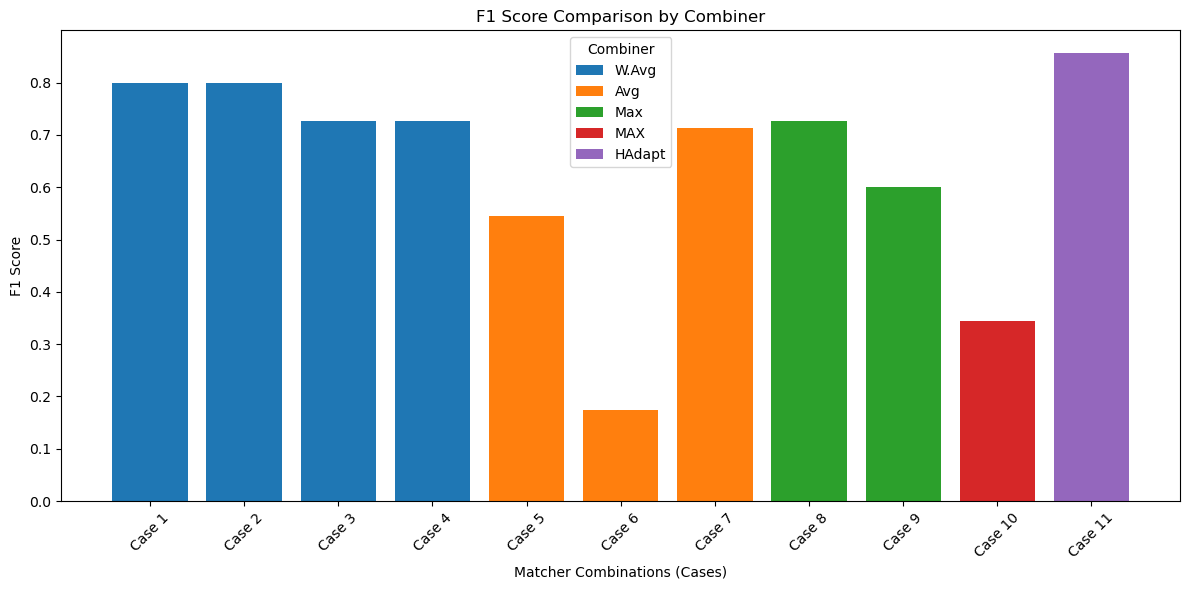

In [26]:
## Evaluation garph

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Evaluation_summary.csv")

df['Combiner'] = df['Combiner'].str.replace('Weighted Avg', 'W.Avg').str.replace('HADAPT', 'HAdapt')


plt.figure(figsize=(12, 6))
for combiner in df['Combiner'].unique():
    subset = df[df['Combiner'] == combiner]
    plt.bar(subset['case'], subset['f1_score'], label=combiner)

plt.xlabel("Matcher Combinations (Cases)")
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison by Combiner")
plt.xticks(rotation=45)
plt.legend(title="Combiner")
plt.tight_layout()

plt.savefig("Latex_tabels/combiner_comparison.pdf")